# Peer Review Project v1.2023Jan 

In [19]:
#installation of packages
!pip install schemdraw
!pip install metapub
!pip install pymed
!pip install pymupdf

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.0 MB 2.7 MB/s            


In [20]:
import pandas as pd
import numpy as np
import requests
import json
import urllib, urllib.request
from concurrent.futures import ThreadPoolExecutor
import schemdraw
from schemdraw.flow import *
from bs4 import BeautifulSoup
from metapub import FindIt
import time

from pymed import PubMed
import xml.etree.ElementTree as ET
import fitz
import re
import io
from io import StringIO
from io import BytesIO
from lxml import etree
# import pprint
from typing import Union

import warnings
warnings.filterwarnings('ignore')

### APIs Used:
- [🔗 Biorvix](https://api.biorxiv.org)
    - Used to retrieve prepublished article data from [Biorvix](https://api.biorxiv.org). 
- [🔗 PubMed](https://github.com/gijswobben/pymed)
    - Used to link the prepublished articles to published articles. 
    - Queries the PubMed database.
    - **Downfall**: 
        - `Title` of an article is often not well recognized it an italicized term is included. 
- [🔗 Metapub](https://github.com/metapub/metapub)
    - Quries PubMed, but returns all article `Titles` without errors. 
    - Returns link to a published PDF file if available on PubMed. 

### Relevant Research:
[ScrapPaper: A web scrapping method to extract journal information from PubMed and Google Scholar search result using Python.](https://www.biorxiv.org/content/10.1101/2022.03.08.483427v1.full.pdf) 

## Workflow

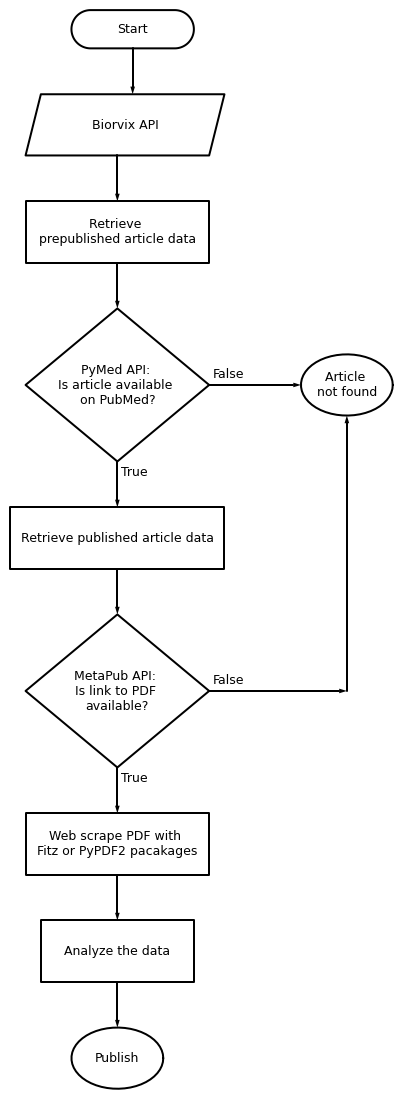

In [12]:
with schemdraw.Drawing() as d:
    d+= Start(w = 4).label("Start")
    d+= Arrow().down(d.unit/2)
    
    d+= Data(w = 6).label("Biorvix API")
    d+= Arrow().down(d.unit/2)
    
    d+= Process(w = 6).label("Retrieve \nprepublished article data")
    d+= Arrow().down(d.unit/2)
    
    d+= (decision := Decision(w = 6, h=5, S="True", E="False").
         label("PyMed API: \nIs article available \non PubMed?"))
    d+= Arrow().down(d.unit/2)
    
    d+= (true := Box(w = 7).label("Retrieve published article data"))
    d+= Arrow().length(d.unit/2)
    
    d+= (decision2 := Decision(w = 6, h=5, S="True", E="False").
         label("MetaPub API: \nIs link to PDF \navailable?"))
    d+= Arrow().down(d.unit/2)
    
    d+= (true := Box(w = 6).label("Web scrape PDF with \nFitz or PyPDF2 pacakages"))
    d+= Arrow().length(d.unit/2)
    
    d+= Box(w=5).label("Analyze the data")
    d+= Arrow().length(d.unit/2)
    
    d+= (end := Ellipse(w=3).label("Publish"))
    
    d+= Arrow().right(d.unit).at(decision.E)
    d+= (end := Ellipse().label("Article \nnot found"))
    
    d+= Arrow().right(d.unit*1.5).at(decision2.E)
    d+= Arrow().up(d.unit*3)

---

## Step 1. Download Prepublished Data with `Biorvix` API

In [13]:
start_time = time.time()

In [14]:
start_interval = "/2022-12-01"
end_interval = "/2022-12-30"

In [15]:
def get_total (url) -> int:
    json_info = get_json_data(url)
    return json_info["messages"][0]["total"]

def get_json_data (url):
    request_API = requests.get(url)
    return json.loads(request_API.text)

def get_data(file, url, loop_range):
    print(f"values: {list(loop_range)}")
    results = []
    with ThreadPoolExecutor(3) as exe:
        if file is not None:
            args = (((get_json_data(f'{url}/{cursor}'), file) for cursor in loop_range))
            print(args)
            exe.map (lambda p: json.dump(*p), args)

            file.close()
        else:
            results = exe.map(get_json_data, ((f'{url}/{cursor}') for cursor in loop_range))
    
    return results

def get_article_detail(url, articles):
    result = get_data(None, url,articles)

    return result
    
def process_data(json_info, keys, cursor):
    journal_list = [[entry + cursor] + [journal[key] for key in keys] for entry, journal in enumerate(json_info["collection"])]
    '''
    for entry, journal in enumerate(json_info["collection"]):
        journal_list.append([entry + cursor, journal["doi"], journal["title"], journal["authors"],
                             journal["author_corresponding"],
                             journal["author_corresponding_institution"],
                             journal["date"], journal["version"], journal["type"],
                             journal["category"], journal["jatsxml"], journal["published"]])
    '''
    return journal_list

freq_count = lambda x,y: x[y].value_counts()

flatten = lambda y: sorted([sublist for inner in y for sublist in inner],
                           key=lambda x:x[0])

create_df = lambda x, y: pd.DataFrame(data=x[:, 1:], index=x[:, 0], columns=y)

In [16]:
# helper functions for published articles
def create_published_df(results, keys, loop_list):
    args = zip(results, 
               [keys for index in loop_list],
               loop_list)

    result_list = []
    with ThreadPoolExecutor(3) as exe:
        result_list = exe.map(lambda p: process_data(*p), args)
    
    df = create_df(np.array(flatten(result_list)),
                   ["DOI", "pub_DOI",
                    "Title", "Authors", "Corresponding_Authors", "Institution",
                    "Category", "Journal", "Preprint_Date", "Published_Date"])
    df['Num_of_Authors'] = df.Authors.apply(lambda x: len(x.split(';')))
    df.DOI = df.DOI.astype('str')
    df.pub_DOI = df.pub_DOI.astype('str')
    df.Title = df.Title.astype('str')
    df.Authors = df.Authors.astype('str')
    df.Corresponding_Authors = df.Corresponding_Authors.astype('str')
    df.Institution = df.Institution.astype('category')
    df.Category = df.Category.astype('category')
    df.Journal = df.Journal.astype('category')
    df.Preprint_Date = pd.to_datetime(df.Preprint_Date, format='%Y-%m-%d')
    df.Published_Date = pd.to_datetime(df.Published_Date, format='%Y-%m-%d')

    return df

In [17]:
base_url: str = 'https://api.biorxiv.org'
query_type: str = '/pubs'
server: str = '/biorxiv'
# start_interval: str = '/2022-11-01'
# end_interval: str = '/2022-12-30'

print(f'{base_url}{query_type}{server}{start_interval}{end_interval}')
results = get_data(None, 
                   f'{base_url}{query_type}{server}{start_interval}{end_interval}', 
                   range(0, get_total(f'{base_url}{query_type}{server}{start_interval}{end_interval}'), 100))

pubs_df = create_published_df([r for r in results], 
                              ["preprint_doi", "published_doi", "preprint_title", "preprint_authors", "preprint_author_corresponding", "preprint_author_corresponding_institution", "preprint_category", "published_journal", "preprint_date", "published_date"],
                              range(0, get_total(f'{base_url}{query_type}{server}{start_interval}{end_interval}'), 100))

print(len(pubs_df))
pubs_df.head()

https://api.biorxiv.org/pubs/biorxiv/2022-12-01/2022-12-30
values: [0, 100, 200]
209


,DOI,pub_DOI,Title,Authors,Corresponding_Authors,Institution,Category,Journal,Preprint_Date,Published_Date,Num_of_Authors
0,10.1101/2020.12.16.423137,10.1016/j.celrep.2021.110124,DNA demethylation switches the drivers of Foxp...,"Li, J.; Xu, B.; Zong, X.; He, M.; Fan, Y.; Cro...",Yongqiang Feng,St. Jude Children's Research Hospital,immunology,Cell Reports,2020-12-16,2022-12-14,8
1,10.1101/2021.01.11.426044,10.1016/j.cell.2021.11.031,Human colorectal pre-cancer atlas identifies d...,"Chen, B.; McKinley, E. T.; Simmons, A. J.; Ram...",Ken Lau,Vanderbilt University,cancer biology,Cell,2021-01-13,2022-12-14,28
2,10.1101/2022.06.10.495632,10.1038/s41467-022-35151-2,Fundamental limits to progression of cellular ...,"Laman Trip, D. S.; Maire, T.; Youk, H.",Hyun Youk,University of Massachusetts Chan Medical School,systems biology,Nature Communications,2022-06-10,2022-12-06,3
3,10.1101/2022.10.07.511272,10.1016/j.omtn.2022.12.006,Multiplex HDR for Disease and Correction Model...,"Iancu, O.; Allen, D.; Knop, O.; Zehavi, Y.; Br...",Ayal Hendel,The Institute for Advanced Materials and Nanot...,bioengineering,Molecular Therapy - Nucleic Acids,2022-10-07,2022-12-09,12
4,10.1101/2022.06.28.497929,10.1016/j.bbapap.2022.140884,Peptide from NSP7 is able to form amyloid-like...,"Garmay, Y. P.; Rubel, A. A.; Egorov, V. V.",Vladimir V Egorov,Petersburg Nuclear Physics Institute,molecular biology,Biochimica et Biophysica Acta (BBA) - Proteins...,2022-06-28,2022-12-01,3


In [18]:
df = pubs_df.copy()
df["Prepub_PDF"] = ""
for ind, row in df.iterrows():
    doi = row["DOI"]
    df.loc[ind, "Prepub_PDF"] = f"https://www.biorxiv.org/content/{doi}.full.pdf"
df

,DOI,pub_DOI,Title,Authors,Corresponding_Authors,Institution,Category,Journal,Preprint_Date,Published_Date,Num_of_Authors,Prepub_PDF
0,10.1101/2020.12.16.423137,10.1016/j.celrep.2021.110124,DNA demethylation switches the drivers of Foxp...,"Li, J.; Xu, B.; Zong, X.; He, M.; Fan, Y.; Cro...",Yongqiang Feng,St. Jude Children's Research Hospital,immunology,Cell Reports,2020-12-16,2022-12-14,8,https://www.biorxiv.org/content/10.1101/2020.1...
1,10.1101/2021.01.11.426044,10.1016/j.cell.2021.11.031,Human colorectal pre-cancer atlas identifies d...,"Chen, B.; McKinley, E. T.; Simmons, A. J.; Ram...",Ken Lau,Vanderbilt University,cancer biology,Cell,2021-01-13,2022-12-14,28,https://www.biorxiv.org/content/10.1101/2021.0...
2,10.1101/2022.06.10.495632,10.1038/s41467-022-35151-2,Fundamental limits to progression of cellular ...,"Laman Trip, D. S.; Maire, T.; Youk, H.",Hyun Youk,University of Massachusetts Chan Medical School,systems biology,Nature Communications,2022-06-10,2022-12-06,3,https://www.biorxiv.org/content/10.1101/2022.0...
3,10.1101/2022.10.07.511272,10.1016/j.omtn.2022.12.006,Multiplex HDR for Disease and Correction Model...,"Iancu, O.; Allen, D.; Knop, O.; Zehavi, Y.; Br...",Ayal Hendel,The Institute for Advanced Materials and Nanot...,bioengineering,Molecular Therapy - Nucleic Acids,2022-10-07,2022-12-09,12,https://www.biorxiv.org/content/10.1101/2022.1...
4,10.1101/2022.06.28.497929,10.1016/j.bbapap.2022.140884,Peptide from NSP7 is able to form amyloid-like...,"Garmay, Y. P.; Rubel, A. A.; Egorov, V. V.",Vladimir V Egorov,Petersburg Nuclear Physics Institute,molecular biology,Biochimica et Biophysica Acta (BBA) - Proteins...,2022-06-28,2022-12-01,3,https://www.biorxiv.org/content/10.1101/2022.0...
...,...,...,...,...,...,...,...,...,...,...,...,...
204,10.1101/2022.01.30.478400,10.1016/j.clim.2022.109209,Clonal dynamics of SARS-CoV-2-specific T cells...,"Khoo, W. H.; Jackson, K.; Phetsouphanh, C.; Za...",Tri Giang Phan,Garvan Institute,immunology,Clinical Immunology,2022-02-01,2022-12-17,38,https://www.biorxiv.org/content/10.1101/2022.0...
205,10.1101/2022.05.11.490027,10.1093/pnasnexus/pgac274,Botrytis cinerea identifies host plants via th...,"Kuroyanagi, T.; Bulasag, A.; Fukushima, K.; Su...",Daigo Takemoto,Nagoya University,microbiology,PNAS Nexus,2022-05-11,2022-12-21,10,https://www.biorxiv.org/content/10.1101/2022.0...
206,10.1101/2022.04.27.489689,10.1093/evolut/qpac045,The distribution of the Lansing Effect across ...,"Ivimey-Cook, E. R.; Shorr, S.; Moorad, J.",Jacob Moorad,University of Edinburgh,evolutionary biology,Evolution,2022-04-28,2022-12-16,3,https://www.biorxiv.org/content/10.1101/2022.0...
207,10.1101/2022.01.06.475185,10.3389/fmolb.2022.1062027,Opposite roles of Rad5 in DNA damage tolerance...,"Maslowska, K. H.; Pages, V.",Vincent Pagès,CNRS,molecular biology,Frontiers in Molecular Biosciences,2022-01-06,2022-12-01,2,https://www.biorxiv.org/content/10.1101/2022.0...


## Step 2. Link Published Data from `PubMed API` to Prepublished Data

In [10]:
from metapub import CrossRefFetcher

doi_list = df["pub_DOI"].tolist()

NCBI_API_KEY = "0a7eb22511543e817f68c81718cc62f35408"

pub_df = pd.DataFrame(columns=["Title", "Pub_DOI", "Num_of_Authors"])
absence_list = []

pubmed = PubMed(tool="MyTool", email="jenny.jeeun@gmail.com")
title_fetch = CrossRefFetcher() 

def query_pubmed(doi):
    query = list(pubmed.query(doi, max_results=10))
    
    if len(query) == 0:
        absence_list.append(doi)
        return [0, "DNE", doi]
        
    for article in query:
        num_authors = len(article.authors)
        title = title_fetch.article_by_doi(doi).title[0]
        doi = doi
    return num_authors, title, doi

start = time.time()

# with ThreadPoolExecutor(max_workers=1) as exe:
#     exe.map(lambda x: query_pubmed(x), doi_list)

for a_doi in doi_list:
    num, title, doi = query_pubmed(a_doi)
    pub_df.loc[len(pub_df)] = [title, doi, num]
    
print("List of journals missing from PubMed database:\n", absence_list)

for ind, row in pub_df.iterrows():
    if (row["Num_of_Authors"] == 0):
        pub_df = pub_df.drop(ind)
        
end = time.time()
        
print("\nTime spent to complete the task:", end - start, "seconds")
pub_df 

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [ ]:
def find_pdf(df):

    df["Pub_PDF"] = ""
    for ind, row in df.iterrows():
        doi = row["Pub_DOI"]
        try:
            pdf = FindIt(doi=doi).url
            if pdf == None:
                pdf = "DNE"
            df.loc[ind, "Pub_PDF"] = pdf
        except:
            df.loc[ind, "Pub_PDF"] = "DNE"
    return df
        
pdf_df = find_pdf(pub_df)
pdf_df.head()

In [ ]:
print(pdf_df.columns)
print(df.columns)

In [ ]:
pdf_df = pdf_df.rename(columns={"Num_of_Authors": "Pub_NA",
                               "Title":"Pub_Title"})
df = df.rename(columns={"Num_of_Authors":"Prepub_NA",
                       "Title":"Prepub_Title"})
all_df = df.merge(pdf_df, left_on="pub_DOI", right_on="Pub_DOI")
all_df["Prepub_Title"] = all_df["Prepub_Title"].apply(str.lower)
all_df["Pub_Title"] = all_df["Pub_Title"].apply(str.lower)
all_df1 = all_df[["DOI", "Pub_DOI", "Institution", "Category", "Journal", "Prepub_NA", "Pub_NA",
                 "Prepub_Title", "Pub_Title", "Prepub_PDF", "Pub_PDF"]]
all_df1.head()

In [ ]:
all_df1["Change_NA"] = ""
all_df1["Change_Title"] = ""

for ind, row in all_df1.iterrows():
    if row["Prepub_Title"] == row["Pub_Title"]:
        all_df1.loc[ind, "Change_Title"] = False
    else:
        all_df1.loc[ind, "Change_Title"] = True
    if row["Prepub_NA"] == row["Pub_NA"]:
        all_df1.loc[ind, "Change_NA"] = "Same"
    elif row["Prepub_NA"] > row["Pub_NA"]:
        all_df1.loc[ind, "Change_NA"] = "Decreased"
    elif row["Prepub_NA"] < row["Pub_NA"]:
        all_df1.loc[ind, "Change_NA"] = "Increased"  
        
all_df1.head()

In [ ]:
pdf_exists = all_df1.loc[all_df1["Pub_PDF"] != "DNE"]
print(len(pdf_exists))
pdf_exists.head()

In [ ]:
def analyse_pdf(df):
    df["Prepub_Figures"] = 0
    df["Pub_Figures"] = 0
    df["Prepub_Texts"] = 0
    df["Pub_Texts"] = 0
    df["Prepub_Pages"] = 0
    df["Pub_Pages"] = 0
    
    for ind, row in df.iterrows():
        prepub_pdf = row["Prepub_PDF"]
        pub_pdf = row["Pub_PDF"]
        print(f"Currently at index {ind}.")
        print(prepub_pdf, pub_pdf)
        
        def check_pdf(url):
            text = ""
            text_count = 0
            response = requests.get(url)
            filestream = io.BytesIO(response.content)
            
            try:
                pdf = fitz.open(stream=filestream, filetype="pdf")
                pages = pdf.page_count
                
                for page in range(pdf.page_count):
                    page = pdf.load_page(page)
                    text += page.get_text()
            except:
                raw = response.content
                with BytesIO(my_raw_data) as data:
                    pdf = PyPDF2.PdfFileReader(data)
                    pages = pdf.getNumPages()

                    for page in range(read_pdf.getNumPages()):
                        text += read_pdf.getPage(page).extractText()

            finally:
                text_count = len(text)

                figures = re.findall("(Figure[.]*\s*\d+[.]*)", text)
                figs = re.findall("(Fig[.]*\s*\d+[.]*)", text)
                sub_figures = re.findall("(Figure[.]*\s*[S]+\d+[.]*)", text)
                sub_figs = re.findall("(Fig[.]*\s*[S]+\d+[.]*)", text)
                all_fig = figures + figs
                all_subfig = sub_figures + sub_figs
                all_fig = [fig for fig in all_fig if "\n" not in fig]
                all_subfig = [fig for fig in all_subfig if "\n" not in fig]

                figure_list = []
                subfigure_list = []

                for fig in all_fig:
                    try:
                        fig_num = int(re.search("\d+", fig)[0])
                        figure_list.append(fig_num)
                    except:
                        continue
                        
                for fig in all_subfig:
                    try:
                        subfig_num = int(re.search("\d+", fig)[0])
                        subfigure_list.append(subfig_num)
                    except:
                        continue

                if len(figure_list) > 0:
                    max_num = max(set(figure_list))
                else:
                    max_num = 0
                    
                if len(subfigure_list) > 0:
                    max_sub_num = max(set(subfigure_list))
                else:
                    max_sub_num = 0
                
                print(f"[{url} | Figures: {max_num}, Sub_Figures: {max_sub_num}]")
                figures_num = max_num 

                return figures_num, text_count, pages
        
        prepub_fig, prepub_texts, prepub_pages = check_pdf(prepub_pdf)
        pub_fig, pub_texts, pub_pages = check_pdf(pub_pdf)
        
        df.loc[ind, "Prepub_Figures"] = prepub_fig
        df.loc[ind, "Pub_Figures"] = pub_fig
        df.loc[ind, "Prepub_Texts"] = prepub_texts
        df.loc[ind, "Pub_Texts"] = pub_texts
        df.loc[ind, "Prepub_Pages"] = prepub_pages
        df.loc[ind, "Pub_Pages"] = pub_pages
        
    return df

final_df = analyse_pdf(pdf_exists)
final_df

In [ ]:
final_df["Change_Texts"] = final_df["Prepub_Texts"] - final_df["Pub_Texts"]
final_df["Change_Figures"] = final_df["Prepub_Figures"] - final_df["Pub_Figures"]
final_df["Change_Pages"] = final_df["Prepub_Pages"] - final_df["Pub_Pages"]
final_df

In [ ]:
3200 / 60

In [ ]:
end_time = time.time()
duration = end_time - start_time
print(duration)
print(final_df.columns)

In [ ]:
text_diff = final_df["Change_Texts"].mean()
fig_diff = final_df["Change_Figures"].mean()
page_diff = final_df["Change_Pages"].mean()

print(f"Number of samples collected from duration of {start_interval} to {end_interval}: {len(final_df)}.")
print(f"On average, {text_diff} characters differed from prepublished and published versions.")
print(f"On average, {fig_diff} figures differed from prepublished and published versions.")
print(f"On average, {page_diff} pages differed from prepublished and published versions.")

In [ ]:
print(final_df.Change_Title.value_counts(), "\n")
print(final_df.Change_NA.value_counts())

---

## Junk Code - Please Ignore 

In [ ]:
# def create_prepublish_df(results, keys,  loop_list):
#     args = zip(results, 
#                [keys for index in loop_list],
#                loop_list)
#     #print(f'results: {len(results)} loop_list: {len(list(loop_list))}')
#     result_list = []
#     with ThreadPoolExecutor(3) as exe:
#         result_list = exe.map(lambda p: process_data(*p), args)
    
#     df = create_df(np.array(flatten(result_list)),
#                    ["DOI", "Title", "Authors", "Corresponding_Authors",
#                     "Institution",
#                     "Date", "Version", "Type", "Category", "Xml", "Published"])
#     df['Num_of_Authors'] = df.Authors.apply(lambda x: len(x.split(';')))
#     df.DOI = df.DOI.astype('str')
#     df.Title = df.Title.astype('str')
#     df.Authors = df.Authors.astype('str')
#     df.Corresponding_Authors = df.Corresponding_Authors.astype('str')
#     df.Institution = df.Institution.astype('category')
#     df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
#     df.Type = df.Type.astype('category')
#     df.Xml = df.Xml.astype('str')

#     return df

In [ ]:
# base_url: str = 'https://api.biorxiv.org'
# query_type: str = '/details'
# server: str = '/biorxiv'
# start_interval: str = '/2022-11-01'
# end_interval: str = '/2022-12-30'

# #finding the number of records for a given time period
# #tmp = f"{base_url}/{start_interval}/{end_interval}"
# #tmp = 'https://api.biorxiv.org/details/biorxiv/2020-08-21/2020-08-28'
# print(f'{base_url}{query_type}{server}{start_interval}{end_interval}')
# results = get_data(None, 
#          f'{base_url}{query_type}{server}{start_interval}{end_interval}', 
#          range(0, get_total(f'{base_url}{query_type}{server}{start_interval}{end_interval}'), 100))

# journal_df = create_prepublish_df([r for r in results], 
#                                   ["doi", "title", "authors", "author_corresponding", "author_corresponding_institution", "date", "version", "type", "category", "jatsxml", "published"],
#                                   range(0, get_total(f'{base_url}{query_type}{server}{start_interval}{end_interval}'), 100))

# print(len(journal_df))
# journal_df

In [ ]:
# journal_df_shortened = journal_df[["DOI", "Xml"]]
# df = pubs_df.merge(journal_df_shortened, on="DOI")
# print(len(df))
# df.head()